LSTM

In [58]:
!%pip install yfinance

'%pip' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [59]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [60]:
# Baixar dados históricos da ação MGLU3 dos últimos 5 anos
mglu3 = yf.download('MGLU3.SA', period="5y")


[*********************100%***********************]  1 of 1 completed


In [61]:
print(mglu3.head(5))

Price        Adj Close       Close        High         Low        Open  \
Ticker        MGLU3.SA    MGLU3.SA    MGLU3.SA    MGLU3.SA    MGLU3.SA   
Date                                                                     
2020-02-11  126.532883  126.899994  128.139297  120.960693  124.398003   
2020-02-12  130.426559  130.804962  132.231339  126.853226  127.507957   
2020-02-13  133.014587  133.400497  133.985062  126.502480  128.419891   
2020-02-14  131.335861  131.716904  135.528351  130.945267  134.686554   
2020-02-17  137.211365  137.609451  140.111435  133.634323  135.621887   

Price        Volume  
Ticker     MGLU3.SA  
Date                 
2020-02-11  4057933  
2020-02-12  4501544  
2020-02-13  5878010  
2020-02-14  3921638  
2020-02-17  7887668  


In [62]:
# Pega somente o atributo "Close" e armazena em um array bidimensional
#O array precisa ser bidimensional porque o MinMaxScaler espera uma entrada com esse formato.
mglu3_close = mglu3['Close'].dropna().to_numpy().reshape(-1, 1)

In [ ]:
# Criar um DataFrame com os valores ajustados
data = pd.DataFrame(mglu3_close)
data.columns = ['Close']

In [64]:
# Normalizar os dados para os modelos
scaler = MinMaxScaler(feature_range=(0, 1))
data['Scaled_Close'] = scaler.fit_transform(data[['Close']])

In [65]:
# Função para criar janelas de dados
# janela de dados = quantidade de dias do X
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [66]:
# Criar conjunto de dados
window_size = 60 # 60 ultimos dias
scaled_data = data['Scaled_Close'].values
X, y = create_dataset(scaled_data, window_size)

In [67]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [68]:
# Ajustar o formato para o LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [69]:
# Criar o modelo LSTM
lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.3),
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    LSTM(100),
    Dropout(0.3),
    Dense(1)
])

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [70]:
# Compilar o modelo
# A função de loss é a forma de medir o erro do modelo, que nesse caso
#é o classico erro médio quadrático da que é usado em regressão linear
#otimizador e medida de erro

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [71]:
# Treinar o modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

lstm_model.fit(X_train, y_train, 
               epochs=10, 
               batch_size=32, 
               validation_data=(X_test, y_test),
               callbacks=[early_stopping, reduce_lr], 
               verbose=1)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - loss: 0.0547 - val_loss: 1.2508e-04 - learning_rate: 0.0010
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.0049 - val_loss: 7.5324e-05 - learning_rate: 0.0010
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0036 - val_loss: 7.5298e-05 - learning_rate: 0.0010
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.0043 - val_loss: 2.0317e-05 - learning_rate: 0.0010
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0029 - val_loss: 3.7400e-05 - learning_rate: 0.0010
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0034 - val_loss: 1.8513e-05 - learning_rate: 0.0010
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0032 - val_loss: 4.3805e-05 - learning_rate: 0.0010
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0030 - val_loss: 1.8298e-05 - learning_rate: 0.0010
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0029 - val_loss: 1.0190e-

In [72]:
# Fazer previsões
lstm_predictions = lstm_model.predict(X_test)

# Inverter a normalização
lstm_predictions = scaler.inverse_transform(lstm_predictions)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step


In [73]:
df_teste = pd.DataFrame({
    "Date": mglu3.index[len(X_train) + 60 : len(X_train) + 60 + len(lstm_predictions)],  # Pegando as datas corretas
    "Real": mglu3['Close'].iloc[len(X_train) + 60 : len(X_train) + 60 + len(lstm_predictions)].values.flatten(),
    "Previsão": lstm_predictions.flatten()
})

# Garantindo que a coluna "Date" seja de fato uma data (caso ainda não seja)
df_teste["Date"] = pd.to_datetime(df_teste["Date"])

# Definir "Date" como índice (opcional, se quiser que o gráfico fique melhor organizado)
df_teste.set_index("Date", inplace=True)

In [74]:
df_teste

,Real,Previsão
Date,,
2024-03-05,21.200001,19.812160
2024-03-06,20.600000,19.913452
2024-03-07,20.400000,19.985584
2024-03-08,20.500000,20.019333
2024-03-11,20.000000,20.015402
...,...,...
2025-02-05,6.880000,6.275093
2025-02-06,7.390000,6.383338
2025-02-07,7.070000,6.486536


In [75]:
# Calcular métricas
mae = mean_absolute_error(df_teste["Real"], df_teste["Previsão"])
mse = mean_squared_error(df_teste["Real"], df_teste["Previsão"])
rmse = np.sqrt(mse)
r2 = r2_score(df_teste["Real"], df_teste["Previsão"])

# Exibir resultados
print(f"📊 MÉTRICAS DE ERRO DO MODELO LSTM 📊")
print(f"MAE  (Erro Absoluto Médio)  : {mae:.4f}")
print(f"MSE  (Erro Quadrático Médio): {mse:.4f}")
print(f"RMSE (Raiz do Erro Médio)   : {rmse:.4f}")
print(f"R²   (Coeficiente de Determinação): {r2:.4f}")


📊 MÉTRICAS DE ERRO DO MODELO LSTM 📊
MAE  (Erro Absoluto Médio)  : 0.8345
MSE  (Erro Quadrático Médio): 1.1522
RMSE (Raiz do Erro Médio)   : 1.0734
R²   (Coeficiente de Determinação): 0.9165


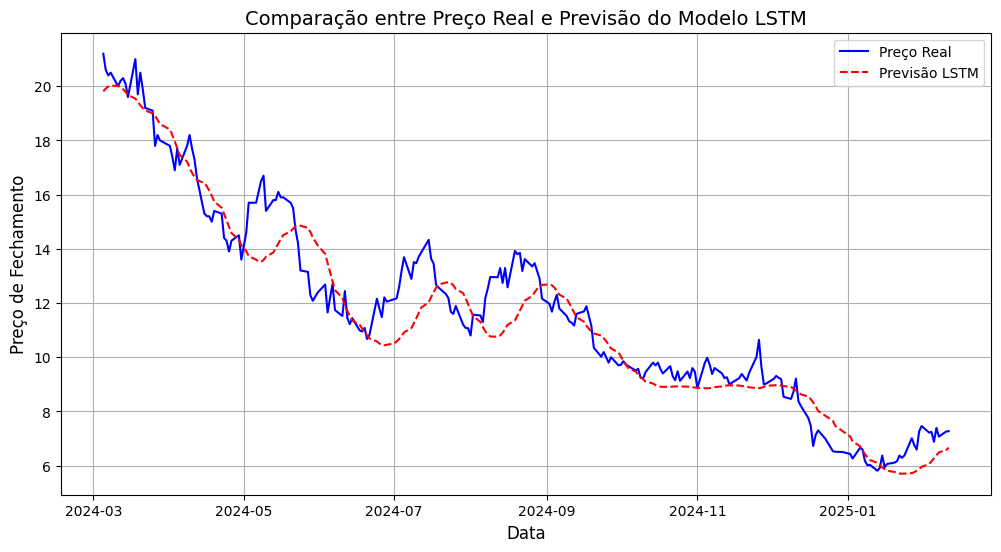

In [76]:
import matplotlib.pyplot as plt

# Criar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_teste.index, df_teste["Real"], label="Preço Real", linestyle="-", color="blue")
plt.plot(df_teste.index, df_teste["Previsão"], label="Previsão LSTM", linestyle="--", color="red")

# Adicionar títulos e legendas
plt.title("Comparação entre Preço Real e Previsão do Modelo LSTM", fontsize=14)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Preço de Fechamento", fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar o gráfico
plt.show()


In [78]:
# Prever o preço de fechamento para os próximos 5 dias
predicted_prices = []
last_60_days = scaled_data[-window_size:]  # Últimos 60 dias da série
last_60_days = last_60_days.reshape(1, window_size, 1)  # Ajustar a forma para o LSTM

for _ in range(5):  # Loop para prever os próximos 5 dias
    # Prever o próximo dia
    predicted_price_scaled = lstm_model.predict(last_60_days)
    predicted_price = scaler.inverse_transform(predicted_price_scaled)
    
    # Adicionar a previsão à lista de preços previstos
    predicted_prices.append(predicted_price[0][0])
    
    # Atualizar 'last_60_days' com o novo preço previsto
    last_60_days = np.append(last_60_days[:, 1:, :], predicted_price_scaled.reshape(1, 1, 1), axis=1)

# Exibir os preços previstos para os próximos 5 dias
for i, price in enumerate(predicted_prices, 1):
    print(f"Preço previsto para o dia {i} (amanhã): R${price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Preço previsto para o dia 1 (amanhã): R$6.73
Preço previsto para o dia 2 (amanhã): R$6.78
Preço previsto para o dia 3 (amanhã): R$6.81
Preço previsto para o dia 4 (amanhã): R$6.83
Preço previsto para o dia 5 (amanhã): R$6.82
